*in the name of Allah*

this code model contains LSTM model

In [ ]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

# For LSTM model
from keras.metrics import RootMeanSquaredError
from keras.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import (SimpleRNN, Dense, LSTM, GRU, Flatten, Dropout, Bidirectional)

!pip install keras-tuner --upgrade
import keras_tuner as kt

#Preprocessing(statistical tests)
https://machinelearningmastery.com/time-series-data-stationary-python/

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

In [3]:
df = pd.read_csv("/content/heart-rate-time-series.csv",header=None)

In [4]:
df.head()

,0
0,91.4634
1,91.4634
2,91.1834
3,91.8788
4,91.1772


In [5]:
df.describe()

,0
count,1800.000000
mean,96.637474
std,5.687179
min,80.213900
25%,92.418925
50%,98.238450
75%,101.362750
max,104.895000


plot our data to see if data is stationary or not.
histogram plot is neccesery to check if we have normal distribution data or not.

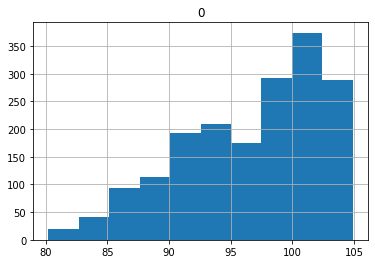

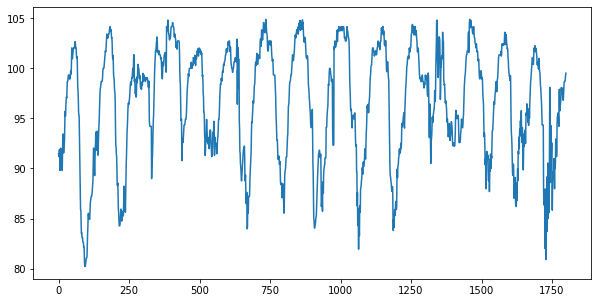

In [6]:
df.hist()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df)
plt.show()

calculate mean and variance in parts of data, to undrestand that our mean
or variance in our data is alike or not.

in this data we have the same mean and variance, so it looks stationary.



In [7]:
x = df.values
split = round(len(x)/2)
x1, x2 = x[:split], x[split:]
mean1, mean2 = x1.mean(), x2.mean()
var1, var2 = x1.var(), x2.var()
print("mean1=%f, mean2=%f" % (mean1,mean2))
print("var1=%f, var2=%f" % (var1,var2))

mean1=96.890504, mean2=96.384444
var1=33.904997, var2=30.619018


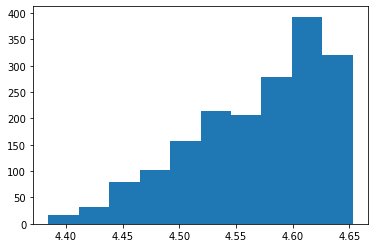

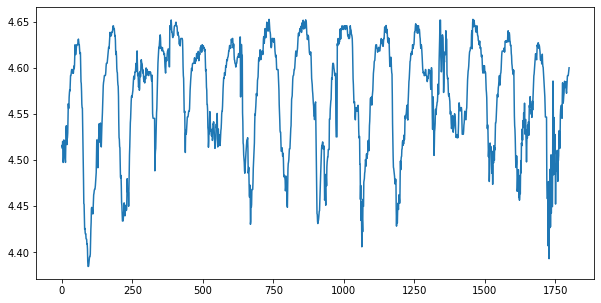

mean1 = 4.571708, mean2 = 4.566664
var1 = 0.003819, var2 = 0.003396


In [8]:
# if we don't have an stationary data we can use log(data) instead
# or something like that to make it stationary to have better result
# our data here is stationary, so this sell is not necessery

x = df.values
log = np.log(x)
plt.hist(log)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(log)
plt.show()

split = round(len(x)/2)
log1, log2 = log[:split], log[split:]
mean1, mean2 = log1.mean(), log2.mean()
var1, var2 = log1.var(), log2.var()
print("mean1 = %f, mean2 = %f" % (mean1,mean2))
print("var1 = %f, var2 = %f" % (var1,var2))

The Augmented **Dickey-Fuller test** is a type of statistical test called a **unit root test**.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [9]:
x = df.values
x = x.reshape((1800))
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.455368
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#Preprocceing(scale and supervised data)

In [10]:
s = MinMaxScaler(feature_range=(-1,1))
df = s.fit_transform(df[[0]])

In [11]:
# convert history(list of minutes) into inputs and outputs, n_out:number of time steps
# returns the data in the overlapping moving window format(5,7,15 minutes)
def to_supervised(train, n_input, n_out):
	# flatten data to have 8 time series sequences.
	data = train
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X),np.array(y)

In [12]:
# split a univariate dataset into train/test sets
def split_dataset(data,n_input,n_out,percent):
	# split into standard weeks
	# Scale features
	x, y = to_supervised(data,n_input,n_out)
	n = int(len(x)*percent)
	train = [x[:n,:], y[:n]]
	test = [x[n:,:], y[n:]]
	return train, test

#build model

In [30]:
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM1 units",min_value=10, max_value=500,step=16), 
			# return_sequences=True
			)
			,input_shape=(n_timesteps, n_features)))
 
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 )))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM3 units",min_value=10,max_value=500,step=16),
	 )))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model

In [31]:
def tune(train,test,name,dir):
  
  #prepare data
  x_train, y_train = train[0], train[1]
  x_test, y_test = test[0], test[1]
  project_name, directory = name , dir
  
  #define parameters
  verbose, epochs, batch_size = 0, 5, 16
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

  #configure tuner
  tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory=directory,
    project_name=project_name
	)
  
  #search for best parameters
  tuner.search(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

  #build best model
  models = tuner.get_best_models(num_models=2)
  best_model = models[0]
  best_model.build(input_shape=(n_timesteps, n_features))
  best_model.summary()
  tuner.results_summary()

  return best_model

# Evaluation

In [32]:
# evaluate a single model
def evaluate_model(train, test,name,dir):
	# compile model
	build_model(kt.HyperParameters())
  
	# tune and fit model
	model = tune(train,test,name,dir)

	# predict test set
	predict = model.predict(test[0])
  # concatinations(I don't know why?!?)
	xtest = test[0].reshape((test[0].shape[0],test[0].shape[1]))
	# predictions = np.concatenate((xtest,predict),axis=1)
	# observation = np.concatenate((xtest,test[1]),axis=1)
	predictions = predict
	observation = test[1]
	
  #calculate rmse and scores
	score, scores = rmse(observation,predictions)
	return predict,score, scores

In [16]:
# Function to return the performance of a model based on multiple seven-day forecasts
# evaluate one or more weekly forecasts against expected values
def rmse(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(len(actual)):
		# calculate mse
		mse = mean_squared_error(actual[i], predicted[i])
		# calculate rmse
		rmse = math.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

#RUN and Plot results

In [33]:
n_input = 360
n_out = 600
name = "BI-LSTM(1 layer)"
dir = "/content"
# split into train and test
train ,test = split_dataset(df,n_input,n_out,0.7)

# evaluate model
t1 = time.time()
predict, score, scores = evaluate_model(train, test ,name ,dir)
t2 = time.time()

print('running time : %.2f min'%((t2-t1)/60))
print('LSTM RMSE : [%.3f]' %(score))

Trial 3 Complete [00h 00m 25s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0019762846641242504
Total elapsed time: 00h 01m 04s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 52)               5824      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 52)                0         
                                                                 
 dense (Dense)               (None, 600)               31800     
                                                                 
Total params: 37,624
Trainable params: 37,624
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in /content/BI-LSTM
Showing 10 best trials
Trial summary
H

#Report results

##RNN Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |        410         |       0.5       |   0.506
        2        |     [394,346]      |    [0.7,0.2]    |   0.515
        3        |    [362,90,138]    |  [0.4,0.2,0.5]  |   0.510
```





```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(SimpleRNN(
			units=hp.Int("RNN1 units",min_value=10, max_value=500,step=16), 
			input_shape=(n_timesteps, n_features),
			return_sequences=True
		))
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(SimpleRNN(
			units=hp.Int("RNN2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(SimpleRNN(
			units=hp.Int("RNN3 units",min_value=10,max_value=500,step=16),
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```



##LSTM Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |         74         |       0.7       |   0.481
        2        |      [106,378]     |    [0.7,0.9]    |   0.508
        3        |     [282,90,346]   |  [0.5,0.7,0.5]  |   0.438
```





```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(LSTM(
			units=hp.Int("lstm1 units",min_value=10, max_value=500,step=16), 
			input_shape=(n_timesteps, n_features),
			return_sequences=True
		))
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(LSTM(
			units=hp.Int("lstm2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(LSTM(
			units=hp.Int("lstm3 units",min_value=10,max_value=500,step=16),
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```



##GRU Report


```
  No. of layers  |    No. of neurons  |     Dropout     |   RMSE
        1        |         122        |       0.7       |   0.482
        2        |       [74,58]      |    [0.8,0.4]    |   0.428
        3        |     [90,42,490]    |  [0.2,0.6,0.1]  |   0.451
```





```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(GRU(
			units=hp.Int("GRU1 units",min_value=10, max_value=500,step=16), 
			input_shape=(n_timesteps, n_features),
			return_sequences=True
		))
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(GRU(
			units=hp.Int("GRU2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(GRU(
			units=hp.Int("GRU3 units",min_value=10,max_value=500,step=16),
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```



##BI-LSTM Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |         90         |       0.6       |   0.457
        2        |       [74,58]      |    [0.8,0.4]    |   0.466
        3        |    [346,106,394]   |  [0.2,0.6,0.7]  |   0.501
```



https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM1 units",min_value=10, max_value=500,step=16), 
			return_sequences=True
			)
			,input_shape=(n_timesteps, n_features)))
 
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 )))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM3 units",min_value=10,max_value=500,step=16),
	 )))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```

